# [Great Energy Prediction](https://www.kaggle.com/c/ashrae-energy-prediction/overview) - Preprocessing
--- 

In this noteboook, I'll describe and explain the reasoning behind my preprocessing.

## Python Libraries
First of all, we need to import some libraries that allows us to work with and visualize the data. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from utils.load_data import load_data
from functools import partial

And our preprocessing functions. Se code for more details.

In [2]:
from utils.preprocessing import filter_groups
from utils.preprocessing import remove_bad_start
from utils.preprocessing import remove_constants
from utils.preprocessing import remove_zeros
from utils.preprocessing import remove_peaks

---
# Preparing Data



In [3]:
train, _, weather, building_information = load_data()
train = train.merge(building_information, on='building_id', how='left')

In [4]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN


## Visualizing changes

In [5]:
def plot_random_examples(df, preprocess_function):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 4))
    building_ids = np.random.choice(df.building_id.unique(), 9)
    col, row = 0, 0
    for building_id in building_ids:
        temp_df = df[df.building_id == building_id].reset_index(drop=True)
        filtered_df = preprocess_function(temp_df)
        filtered_df = filtered_df.meter_reading.reindex(range(len(temp_df)), fill_value=np.nan)
        sns.lineplot(y=temp_df.meter_reading.values, x=list(temp_df.index), ax=axes[col][row])
        sns.lineplot(y=filtered_df.values, x=list(filtered_df.index), ax=axes[col][row])
        axes[col][row].set_xticks([])
        axes[col][row].set_yticks([])
        if col == 2:
            col = 0
            row += 1
        else:
            col += 1
        
    plt.tight_layout()
    plt.show()

---
# Filtering on `site_id` and `meter`.

Many of the obvious anomalies occur at a `site_id` level and are not specific for one building. Since we need to be very careful before we remove values it's comforting when there's a systematic problem over several buildings.

## `site_id: 0` & `meter: 0`

There's a clear pattern for this combination. All sequences with a length of atleast 5000 starts with values that look very different from the following distribution. It's either zeros, or some other values that looks like clear anomalies. To handle this problem, I'll use `remove_bad_start()`. Each sequence have almost exactly the same number of strange values, and I can remove most of them by keeping the last 5,400 values.

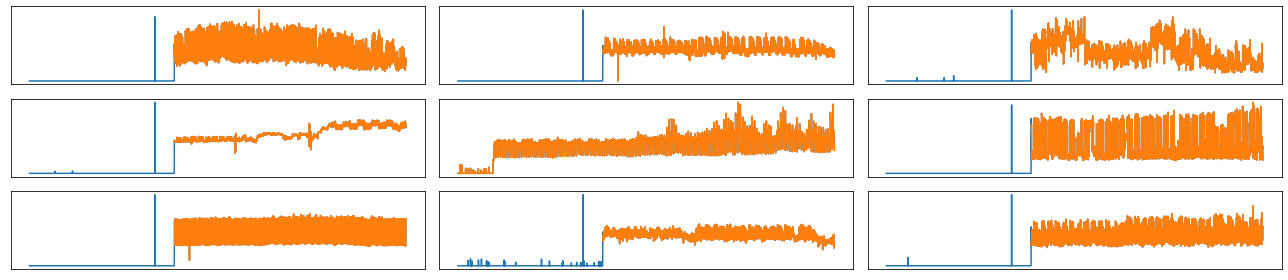

In [6]:
plot_random_examples(
    train[(train.meter == 0) & (train.site_id == 0)], 
    partial(remove_bad_start, n_values_to_keep=5400)
)

For **`site_id: 0`** and **`meter: 1`** There are not as many obvious anomalies, and it's not obvious if we need to remove anything. There are some situations where there are a long sequence of zeroes indicating that we're missing measurements for that period, but it's hard to be certain.

## `site_id: 1` & `meter: 0`

Here there are many examples where we have constant values that look very different from the sporadic behaviour of the rest of the sequence. Since most of the sequences are intact, I feel comfortable removing these anomalies.

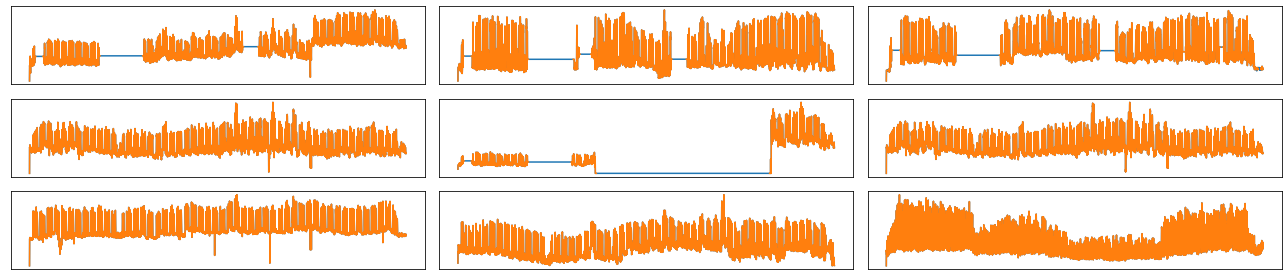

In [7]:
plot_random_examples(
    train[(train.meter == 0) & (train.site_id == 1)], 
    partial(remove_constants, constant_length=50)
)

## `Site_ids: 2,3,4,5,6,7,8,9,10,11,12,13,14,15`

It's very hard to find anything obvious for any of the other sites. The only thing I feel comfortable doing is removing long sequences of zeros for **`meter: 0`**.

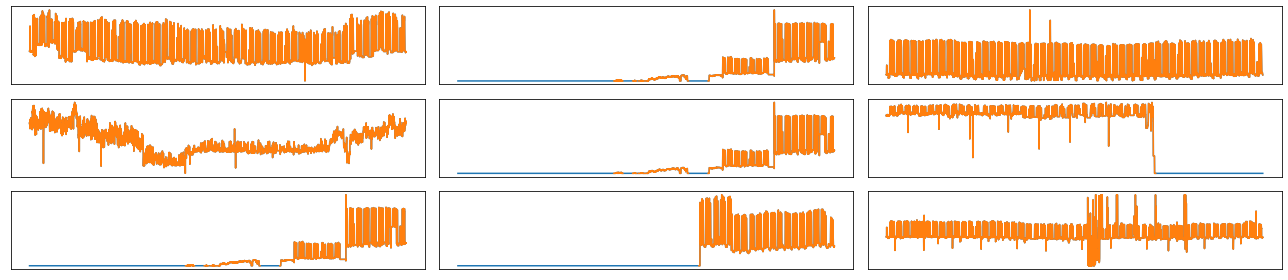

In [103]:
plot_random_examples(
    train[(train.meter == 0) & (train.site_id == 7)], 
    partial(remove_zeros, zero_length=50)
)

---
# Shifting weather data

In [130]:
def normalize_column(df, column):
    df[column] -= df[column].mean()
    df[column] /= df[column].std()
    return df

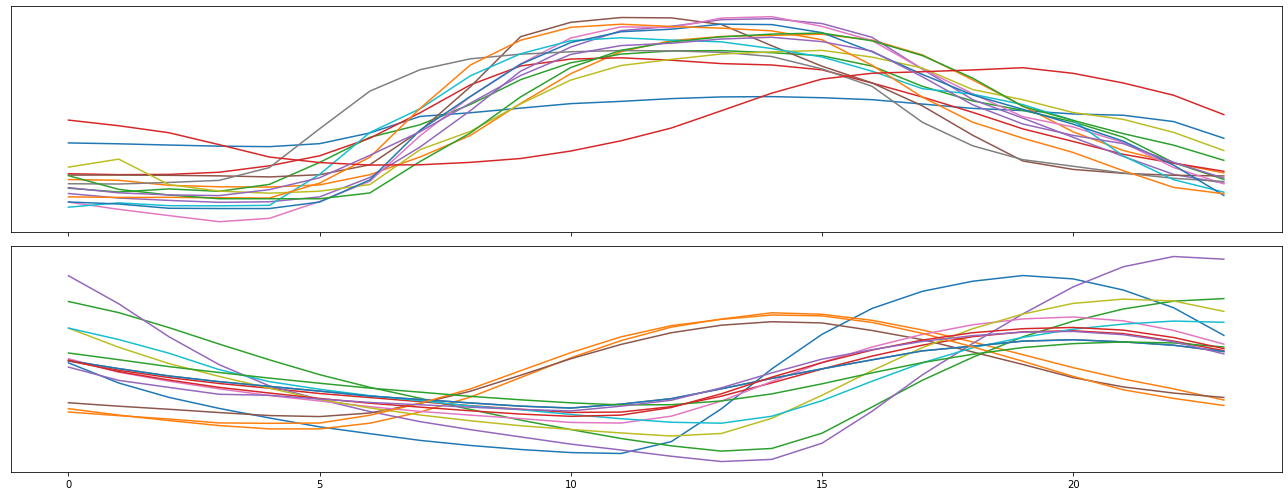

In [134]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 7), sharex=True)

for site_id in train.site_id.unique():
    temp_train = train[(train.site_id == site_id) & (train.primary_use == 'Education') & (train.meter == 0)]
    temp_weather = weather[weather.site_id == site_id]
    if len(temp_train) == 0: continue
    
    temp_train = temp_train.groupby('building_id').apply(lambda group: normalize_meter(group))
    temp_weather = normalize_column(temp_weather, 'air_temperature')
    
    temp_train['hour'] = temp_train.timestamp.dt.hour
    temp_weather['hour'] = temp_weather.timestamp.dt.hour
    
    x = [i for i in range(24)]
    sns.lineplot(y=temp_train.groupby('hour').mean()['meter_reading'].values, x=x, ax=axes[0])
    sns.lineplot(y=temp_weather.groupby('hour').mean()['air_temperature'].values, x=x, ax=axes[1])
    axes[0].set_yticks([])
    axes[1].set_yticks([])
    
plt.tight_layout()
plt.show()

Based on this, it looks like the `timestamp` for the training data is correct but not for the weather data. We expect the `air_temperature` to peak around 15-16, but for most of the sites, it peaks around 20, which can't be correct. It's probably good to shift the weather data for the the sites where it seems to be off, but it's hard to do correctly without knowing the exact locations. Here are the max hours for the different sites.

In [143]:
for _, df in weather.groupby('site_id'):
    df['hour'] = df.timestamp.dt.hour
    max_hour = df.groupby('hour').mean()['air_temperature'].sort_values().index[-1]
    print(df.iloc[0].site_id, ':', max_hour)

0 : 19
1 : 14
2 : 23
3 : 20
4 : 22
5 : 14
6 : 20
7 : 20
8 : 19
9 : 21
10 : 22
11 : 20
12 : 14
13 : 21
14 : 20
15 : 20


To me it seems like we have UTC time in the weather data and local times in the training data. If that is true, and if the warmest hours are 15-16, sites:
- `1,5,12` are somewhere in Europe (maybe Germany) and we should add 2 hours
- `0,3,6,7,8,11,14,15` are somewhere along the east-coast in the US and we should subtract 4-5 hours
- `2,4,10,13` are somewhere along the west-coast in the US and we should subtract 6-7 hours 

We can try and see if things work out. If we get one hour wrong, it should still be better than what it is right now.

In [149]:
def adjust_timestamp(df):
    df['hour'] = df.timestamp.dt.hour
    max_hour = df.groupby('hour').mean()['air_temperature'].sort_values().index[-1]
    n_hours = 16 - max_hour
    df.timestamp = df.timestamp +  pd.to_timedelta(n_hours, unit='h')
    return df

In [150]:
weather_ = weather.groupby('site_id').apply(lambda group: adjust_timestamp(group))

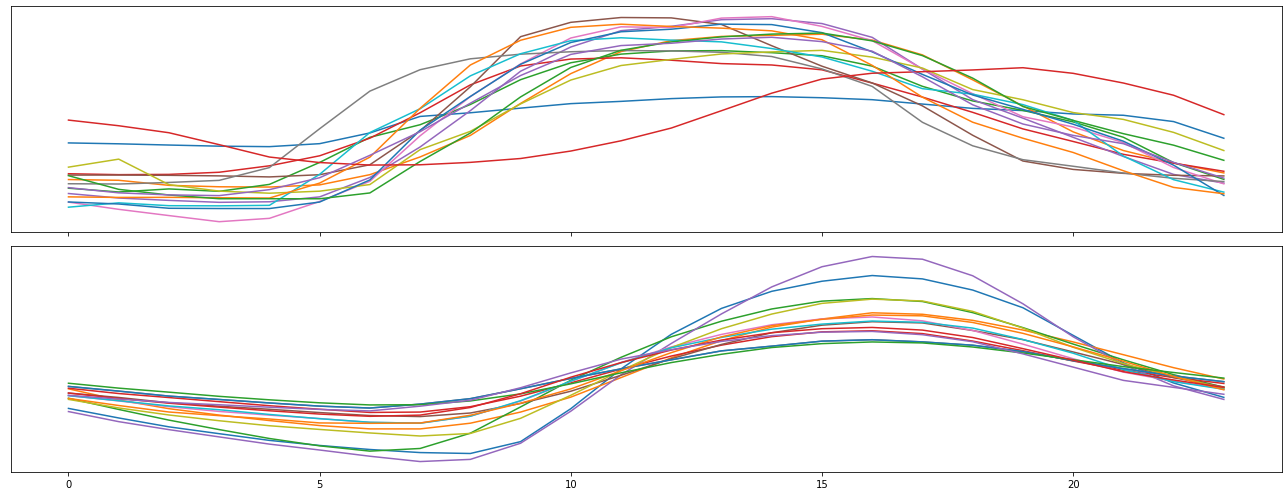

In [151]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 7), sharex=True)

for site_id in train.site_id.unique():
    temp_train = train[(train.site_id == site_id) & (train.primary_use == 'Education') & (train.meter == 0)]
    temp_weather = weather_[weather_.site_id == site_id]
    if len(temp_train) == 0: continue
    
    temp_train = temp_train.groupby('building_id').apply(lambda group: normalize_meter(group))
    temp_weather = normalize_column(temp_weather, 'air_temperature')
    
    temp_train['hour'] = temp_train.timestamp.dt.hour
    temp_weather['hour'] = temp_weather.timestamp.dt.hour
    
    x = [i for i in range(24)]
    sns.lineplot(y=temp_train.groupby('hour').mean()['meter_reading'].values, x=x, ax=axes[0])
    sns.lineplot(y=temp_weather.groupby('hour').mean()['air_temperature'].values, x=x, ax=axes[1])
    axes[0].set_yticks([])
    axes[1].set_yticks([])
    
plt.tight_layout()
plt.show()

That looks better